# Future Asset Score Prediction

### Packages/Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

In [3]:
warnings.filterwarnings("ignore")

### Training data

In [4]:
df = pd.read_excel("data.xlsx")

### Exploratory Data Analysis (EDA)

In [5]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type
0,0.9993,8,0.9850,8,N,10,8.8,0.0969,0.105,2031-10-17,N,NR,Ca,First Lien Senior Secured
1,0.9975,8,0.9102,8,N,10,8.8,0.0969,0.105,2031-10-17,N,NR,Ca,First Lien Senior Secured
2,0.0000,1,0.0000,1,N,10,4.6,0.1054,0.105,2030-05-08,N,B+,Ba3,First Lien Senior Secured
3,0.0000,1,0.0000,1,N,10,4.6,0.1054,0.105,2030-05-08,N,B+,Ba3,First Lien Senior Secured
4,1.0106,10,0.9925,8,N,10,9.4,0.1055,0.105,2030-05-08,N,B+,Ba3,First Lien Senior Secured


In [6]:
df.columns

Index(['FV % of Cost', 'FV % of Cost Score', 'FV / Par', 'FV / Par Score',
       'Non Accrual Loans', 'Non-Accrual Socre', 'Current Score',
       'All-in-Yield', 'Average Yield', 'Maturity', 'Non Qualifying',
       'Investee S&P Ratings', 'Investee Moodys Ratings', 'Security Type'],
      dtype='object')

In [7]:
df.describe()

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity
count,142432.000000,142432.000000,142432.000000,142432.000000,142432.000000,142432.000000,135609.000000,142432.000000,141808
mean,0.788406,7.510258,0.768370,7.050445,9.775823,8.278540,0.104439,0.108725,2029-01-03 06:02:14.040392704
min,-22.803300,1.000000,-20.666700,1.000000,0.000000,0.600000,0.001300,0.105000,2015-01-05 00:00:00
25%,0.906200,8.000000,0.815000,8.000000,10.000000,7.300000,0.093900,0.105000,2027-08-31 00:00:00
50%,1.000000,10.000000,0.990000,8.000000,10.000000,9.400000,0.103100,0.110000,2028-11-30 00:00:00
75%,1.008100,10.000000,1.000000,10.000000,10.000000,10.000000,0.113300,0.110000,2030-03-31 00:00:00
max,8.987800,10.000000,10.000000,10.000000,10.000000,10.000000,4.157200,0.115000,2123-01-31 00:00:00
std,0.437937,3.525118,0.424134,3.432167,1.480382,2.204644,0.023183,0.004119,NaN


### Data Preprocessing

In [8]:
def convert_yields_into_number(series):
    return series.apply(lambda x: 
                        2.00 if pd.isna(x) 
                        else float(x * 100))

In [9]:
df["All-in-Yield"] = convert_yields_into_number(df["All-in-Yield"])
df["Average Yield"] = convert_yields_into_number(df["Average Yield"])

In [10]:
def set_all_in_yield_score(row):
    diff = row["All-in-Yield"] - row["Average Yield"]
    
    if diff <= 1.00:
        return 10.00
    elif 1.00 < diff < 3.00:
        return 8.00
    elif 3.00 <= diff < 5.00:
        return 6.00
    elif diff >= 5.00:
        return 4.00

In [11]:
df['All in Yield Score'] = df.apply(set_all_in_yield_score, axis=1)

In [12]:
df.head()

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0


In [13]:
def set_non_qualifying(row):
    if row['Non Qualifying'] == 'Y':
        return 5
    elif row['Non Qualifying'] == 'N':
        return 10

In [14]:
df['Non Qualifying Score'] = df.apply(set_non_qualifying, axis=1)

In [15]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score,Non Qualifying Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10


In [16]:
def calculate_maturity_score(maturity_series):
    today = pd.Timestamp.today()
    
    def score(row):
        if pd.isna(row):
            return 2
        try:
            maturity_date = pd.to_datetime(row)
            months = (maturity_date.year - today.year) * 12 + (maturity_date.month - today.month)
            if months < 0:
                months = 0  

            if months < 12:
                return 10
            elif 12 <= months < 24:
                return 9
            elif 24 <= months < 36:
                return 8
            elif 36 <= months < 48:
                return 7
            elif 48 <= months < 60:
                return 5
            elif months >= 60:
                return 3
        except:
            return 2

    return maturity_series.apply(score)

In [17]:
df["Maturity Score"] = calculate_maturity_score(df["Maturity"])

In [18]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score,Non Qualifying Score,Maturity Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5


In [19]:
def calculate_security_type_score(security_type_series):
    mapping = {
        "First Lien Senior Secured": 10,
        "Second Lien Senior Secured": 8,
        "Subordinated": 6,
        "Other": 4
    }
    
    return security_type_series.map(mapping).fillna(4)

In [20]:
df["Security Type Score"] = calculate_security_type_score(df["Security Type"])

In [21]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score,Non Qualifying Score,Maturity Score,Security Type Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10


In [22]:
def calculate_rating_score(rating_series):
    rating_map = {
        "AAA": 10,
        "AA+": 9.5,
        "AA": 9,
        "AA-": 8.5,
        "BBB+": 8,
        "BBB": 7.5,
        "BBB-": 7,
        "BB+": 6.5,
        "BB": 6,
        "BB-": 5.5,
        "B+": 5,
        "B": 4.5,
        "B-": 4,
        "CCC+": 3.5,
        "CCC": 3.2,
        "CCC-": 3,
        "CC+": 2.8,
        "CC": 2.6,
        "CC-": 2.5,
        "C+": 2,
        "C": 1.5,
        "C-": 1.5,
        "SD": 1.5,
        "D": 1,
        "NR": 1,
        "": 2
    }

    return rating_series.map(rating_map).fillna(2)

In [23]:
df["SP Rating Score"] = calculate_rating_score(df["Investee S&P Ratings"])

In [24]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score,Non Qualifying Score,Maturity Score,Security Type Score,SP Rating Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10,1.0
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10,1.0
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0


In [25]:
def calculate_moodys_rating_score(rating_series):
    rating_map = {
        "Aaa": 10,
        "Aa1": 9.5,
        "Aa2": 9,
        "Aa3": 8.5,
        "A1": 8,
        "A2": 7.5,
        "A3": 7,
        "Baa1": 6.5,
        "Baa2": 6,
        "Baa3": 5.5,
        "Ba1": 5,
        "Ba2": 4.5,
        "Ba3": 4,
        "B1": 3.5,
        "B2": 3,
        "B3": 2.5,
        "Caa1": 2,
        "Caa2": 1.5,
        "Caa3": 1.5,
        "Ca": 1,
        "C": 1,
        "WR": 1
    }
    return rating_series.map(rating_map).fillna(2)

In [26]:
df["Moodys Rating Score"] = calculate_moodys_rating_score(df["Investee Moodys Ratings"])

In [27]:
df.head(5)

,FV % of Cost,FV % of Cost Score,FV / Par,FV / Par Score,Non Accrual Loans,Non-Accrual Socre,Current Score,All-in-Yield,Average Yield,Maturity,Non Qualifying,Investee S&P Ratings,Investee Moodys Ratings,Security Type,All in Yield Score,Non Qualifying Score,Maturity Score,Security Type Score,SP Rating Score,Moodys Rating Score
0,0.9993,8,0.9850,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10,1.0,1.0
1,0.9975,8,0.9102,8,N,10,8.8,9.69,10.5,2031-10-17,N,NR,Ca,First Lien Senior Secured,10.0,10,3,10,1.0,1.0
2,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0,4.0
3,0.0000,1,0.0000,1,N,10,4.6,10.54,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0,4.0
4,1.0106,10,0.9925,8,N,10,9.4,10.55,10.5,2030-05-08,N,B+,Ba3,First Lien Senior Secured,10.0,10,5,10,5.0,4.0


In [28]:
X = df[['All in Yield Score', 'Non Qualifying Score', 'Maturity Score', 'Security Type Score', 'SP Rating Score', 'Moodys Rating Score']]
y = df[['Current Score']]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

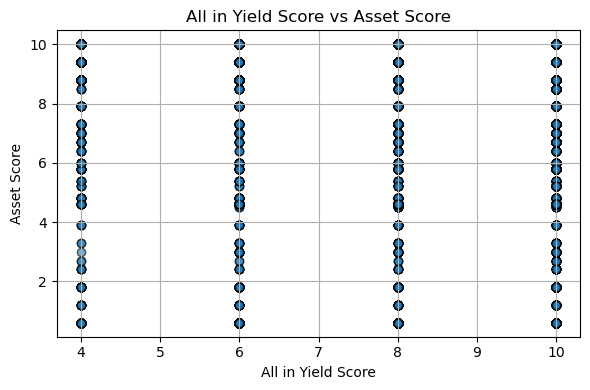

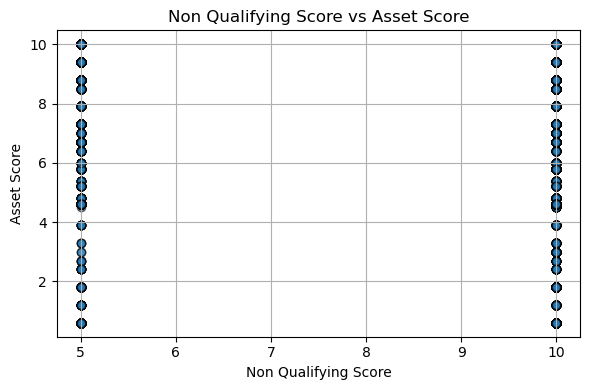

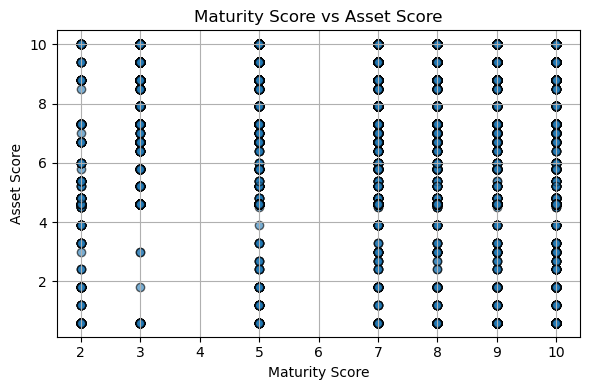

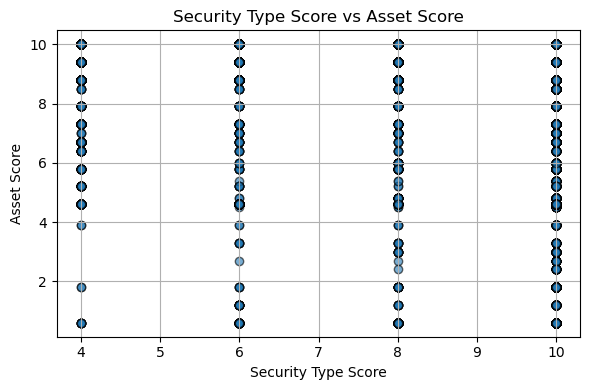

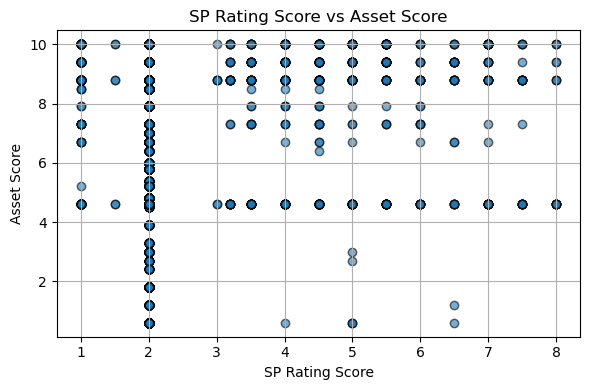

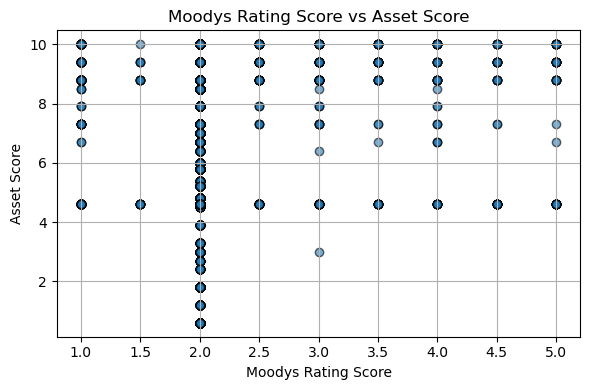

In [30]:
for feature in X:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_train[feature], y_train, alpha=0.6, edgecolors='k')
    plt.title(f"{feature} vs Asset Score")
    plt.xlabel(feature)
    plt.ylabel("Asset Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Feature Engineering

Feature engineering is the process of selecting, transforming, and creating new features from raw data to improve the performance of machine learning models. It involves manipulating existing data or creating new variables to make the data more suitable for the specific machine learning algorithm being used. 

# Training Features

### 1. All in Yield Score
### 2. Non Qualifying Score
### 3. Maturity Score
### 4. Security Type Score
### 5. SP Rating Score
### 6. Moodys Rating Score
# Output Feature
## Asset score

# Machine Learning model
### LINEAR REGRESSION MODEL
LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
y_predicted = model.predict(X_test)

## Evaluation



### Mean Squared Error
Mean Squared Error (MSE) is a commonly used metric in regression analysis and machine learning to evaluate the performance of a model. It quantifies the average squared difference between predicted and actual values, providing a measure of the model's error. 


In [33]:
print("Linear Regression Model Score:", model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, y_predicted))

Linear Regression Model Score: 0.00604446089473476
Mean Squared Error: 4.855420440359449


### GradientBoostingRegressor Model

In [34]:
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [35]:
gbr_y_pred = gbr_model.predict(X_test)

### GBR Score

In [36]:
print("Gradient Boosting Regressor Score:",gbr_model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, gbr_y_pred))

Gradient Boosting Regressor Score: 0.048939791152838974
Mean Squared Error: 4.645879012059092


### HistGradientBoostingRegressor

In [37]:
hgbr_model = HistGradientBoostingRegressor()
hgbr_model.fit(X_train, y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [38]:
hgbr_y_predict = hgbr_model.predict(X_test)

### HGBR Score

In [39]:
print("Hist Gradient Boosting Regresssor Score:",hgbr_model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, hgbr_y_predict))

Hist Gradient Boosting Regresssor Score: 0.054453760401251605
Mean Squared Error: 4.618943562793065


### RandomForestRegressor 

In [40]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_test, y_test)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
rfr_y_predict = rfr_model.predict(X_test)

### RFR Score

In [42]:
print("Random Forest Regression Score:",rfr_model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, rfr_y_predict))

Random Forest Regression Score: 0.0661157316116956
Mean Squared Error: 4.561975447860032


### Supprot Vector Regression

In [43]:
svr_model = SVR()
svr_model.fit(X_train,y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [44]:
svr_y_predict = svr_model.predict(X_test)

In [45]:
print("Support Vector Regression Score:",svr_model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, svr_y_predict))

Support Vector Regression Score: -0.15418072605284072
Mean Squared Error: 5.638112036872883


### Cross Val Score

In [46]:
models = {
    # "SVR": SVR(),
    "Random Forest" : RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(),
    "Linear Regression": LinearRegression()
}

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    r2 = cross_val_score(model, X, y, cv=kfold, scoring="r2")
    mae = cross_val_score(model, X, y, cv=kfold, scoring="neg_mean_absolute_error")
    rmse = cross_val_score(model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

    results[name] = {
        "R2": np.mean(r2),
        "MAE": -np.mean(mae),
        "RMSE": -np.mean(rmse)
    }
for model_name, scores in results.items():
    print(f"{model_name}:\n R2: {scores['R2']:.4f}\n MAE: {scores['MAE']:.4f}\n RMSE: {scores['RMSE']:.4f}\n")

Random Forest:
 R2: 0.0510
 MAE: 1.7123
 RMSE: 2.1470

Gradient Boosting:
 R2: 0.0469
 MAE: 1.7215
 RMSE: 2.1517

Hist Gradient Boosting:
 R2: 0.0517
 MAE: 1.7127
 RMSE: 2.1460

Linear Regression:
 R2: 0.0055
 MAE: 1.7720
 RMSE: 2.1979



In [48]:
best_model = min(results, key=lambda x: results[x]['RMSE'])
print(f"Best model based on RMSE: {best_model}")

Best model based on RMSE: Hist Gradient Boosting
